In [8]:
import cv2
import openai
import numpy as np
import tkinter as tk
import mediapipe as mp
import helper
from PIL import Image
import copy
import compare_keypoints
import math

In [2]:
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose = mp_pose.Pose(static_image_mode=True)

I0000 00:00:1747360806.261071 1832813 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M1 Pro


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1747360806.437761 1832993 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747360806.462398 1832991 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [106]:
limbSeqToCompare = [[2, 3], [2, 6], [3, 4], [4, 5], [6, 7], [7, 8], [2, 9], [9, 10], \
            [10, 11], [2, 12], [12, 13], [13, 14], [2, 1]]
joinName = {
    1: "Head",
    2: "Neck",
    3: "Right Shoulder",
    4: "Right Elbow",
    5: "Right Wrist",
    6: "Left Shoulder",
    7: "Left Elbow",
    8: "Left Wrist",
    9: "Right Hip",
    10: "Right Knee",
    11: "Right Ankle",
    12: "Left Hip",
    13: "Left Knee",
    14: "Left Ankle",
    15: "Right Eye",
    16: "Left Eye",
    17: "Right Ear",
    18: "Left Ear",   
}
def determineSizeMoving(angle):
    if angle<30:
        return "a little bit"
    else:
        return "a big step"
def getVectors(kps,limbSeq):
    return np.array([[kps[limbSeq[i][0]-1][0] - kps[limbSeq[i][1]-1][0],kps[limbSeq[i][0]-1][1] - kps[limbSeq[i][1]-1][1],kps[limbSeq[i][0]-1][2] + kps[limbSeq[i][1]-1][2]] if kps[limbSeq[i][0]-1][2]!=0 and kps[limbSeq[i][1]-1][2]!=0 else [0,0,0] for i in range(len(limbSeq))])

def getAngleSetAndScore(vect1,vect2):
    vect1 = vect1[:, :2]
    vect2 = vect2[:, :2]

    cross = vect1[:, 0] * vect2[:, 1] - vect1[:, 1] * vect2[:, 0]
    dot = np.sum(vect1 * vect2, axis=1)
    angles = np.arctan2(cross, dot)
    angles = np.degrees(angles)
    
    scores = np.exp(-np.abs(angles) / 50.0)
    scores = np.clip(scores, 1e-8, 1)
    weights = 1/scores
    weights = weights/(sum(weights))
    final_score = np.sum(scores * weights)
    
    return -angles,final_score
def compare_keypoints(keypoints1,keypoints2,compareImg=None,guide=True,gpt=True):

    vectors1 = getVectors(keypoints1,limbSeqToCompare)
    vectors2 = getVectors(keypoints2,limbSeqToCompare)

    if not guide:
        return getAngleSetAndScore(vectors1,vectors2)
    angles,score = getAngleSetAndScore(vectors1,vectors2)
    
    # find joints need to improve
    potential_pairs = np.array(limbSeqToCompare)[np.abs(angles)>10]
    potential_angles = angles[np.abs(angles)>10]
    potential_vectors = vectors2[np.abs(angles)>10]
    
    
    guide = ""
    canvas = copy.deepcopy(compareImg)
    for i in range(len(potential_pairs)):
        start_point = np.array(keypoints2[potential_pairs[i][1]-1][:2]).astype(int)
        if abs(potential_vectors[i][1])>abs(potential_vectors[i][0]):
            if potential_vectors[i][1]>0:
                end_point = [start_point[0] + int(potential_angles[i]/2),start_point[1]]
            else:
                end_point = [start_point[0] - int(potential_angles[i]/2),start_point[1]]
            direction = "left" if end_point[0]>start_point[0] else "right"
            guide = guide + f"Move your {joinName[potential_pairs[i][1]]} to the {direction} {determineSizeMoving(abs(potential_angles[i]))}. \n"
        else:
            if potential_vectors[i][0]<0:
                end_point = [start_point[0],start_point[1]+ int(potential_angles[i]/2)]
            else:
                end_point = [start_point[0],start_point[1]- int(potential_angles[i]/2)]
            direction = "down" if end_point[1]>start_point[1] else "up"
            guide = guide + f"Move your {joinName[potential_pairs[i][1]]} to the {direction} {determineSizeMoving(abs(potential_angles[i]))}. \n"
        color = (0, 255, 0) 
        thickness = 2
        tip_length = 0.5
        

        cv2.arrowedLine(canvas, start_point, end_point, color, thickness, tipLength=tip_length)

    # horizontal = cv2.hconcat([oriImg, compareImg, canvas])
    if gpt:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": f'''You are a photographer and you are taking pictures of a client. 
                    You have provided them with a photo of a model with a nice pose and your client is copying that pose.
                    After taking the first photo, the matching score is {score}% and you want to ask the client to change a few things to get the perfect:
                    {guide}. Please make the tutorial more natural and concise
                    '''}
            ]
        )
        guide = response.choices[0].message.content
        
    
    return canvas, score, guide 

In [35]:
limbSeq = [[2, 3], [2, 6], [3, 4], [4, 5], [6, 7], [7, 8], [2, 9], [9, 10], \
    [10, 11], [2, 12], [12, 13], [13, 14], [2, 1]]
colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
        [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
        [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]

def draw_bodypose(canvas, candidate):
    stickwidth = 4

    # Draw keypoints
    for i in range(14):
        x, y = candidate[i][0:2]
        if x == 0 and y == 0:
            continue
        cv2.circle(canvas, (int(x), int(y)), 4, colors[i % len(colors)], thickness=-1)

    # Draw limbs
    for idx, (i, j) in enumerate(limbSeq):
        if (candidate[i - 1][0] == 0 and candidate[i - 1][1] == 0) or \
           (candidate[j - 1][0] == 0 and candidate[j - 1][1] == 0):
            continue

        x1, y1 = candidate[i - 1][0:2]
        x2, y2 = candidate[j - 1][0:2]

        # midpoint and length
        mX = int((x1 + x2) / 2)
        mY = int((y1 + y2) / 2)
        length = math.hypot(x2 - x1, y2 - y1)
        angle = math.degrees(math.atan2(y2 - y1, x2 - x1))

        # ellipse as limb
        polygon = cv2.ellipse2Poly((mX, mY), (int(length / 2), stickwidth), int(angle), 0, 360, 1)
        cur_canvas = canvas.copy()
        cv2.fillConvexPoly(cur_canvas, polygon, colors[idx % len(colors)])
        canvas = cv2.addWeighted(canvas, 0.6, cur_canvas, 0.4, 0)

    return canvas

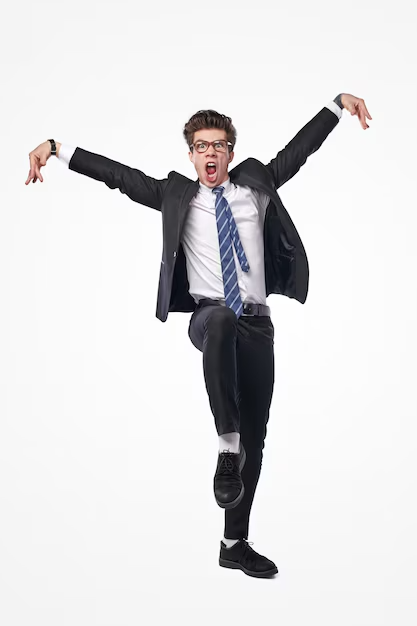

In [36]:
image = cv2.imread("funny-businessman-standing-kung-fu-pose_251859-5363.avif")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = pose.process(image)
# if results.pose_landmarks:
#     mp_drawing.draw_landmarks(
#         image,
#         results.pose_landmarks,
#         mp_pose.POSE_CONNECTIONS,
#         mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2),
#         mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2)
#     )
keypoint1 = helper.convert_mediapipe_to_openpose(
            results.pose_landmarks.landmark, image.shape[1], image.shape[0])
Image.fromarray(image)

In [37]:
image = draw_bodypose(image, keypoint1)

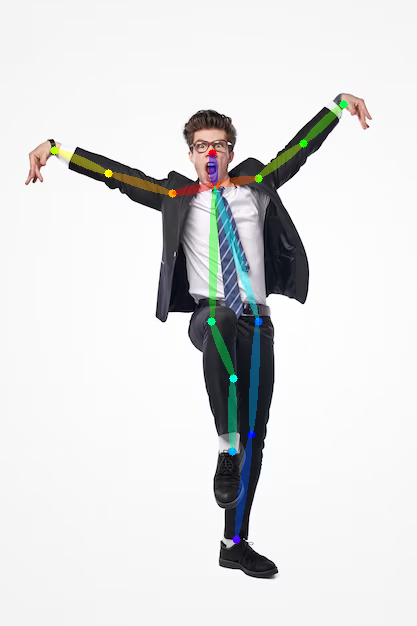

In [38]:
Image.fromarray(image)

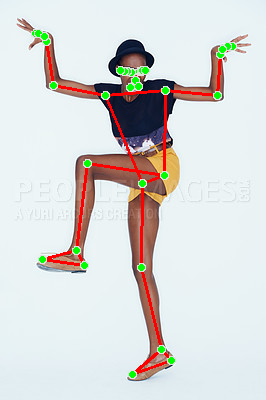

In [4]:
image = cv2.imread("433169-playful-posing-fit_400_400.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = pose.process(image)
if results.pose_landmarks:
    mp_drawing.draw_landmarks(
        image,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2),
        mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2)
    )
keypoint2 = helper.convert_mediapipe_to_openpose(
            results.pose_landmarks.landmark, image.shape[1], image.shape[0])
Image.fromarray(image)

In [6]:
canvas, score, guide = compare_keypoints.compare_keypoints(keypoint1,keypoint2,image,gpt=False)

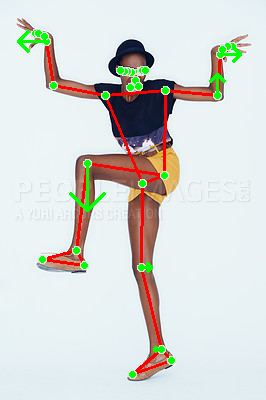

In [7]:
Image.fromarray(canvas)

In [ ]:
cap = cv2.VideoCapture(0)
def update_frame():
    ret, frame = cap.read()
    if ret:
        # Mirror and convert color
        frame = cv2.flip(frame, 1)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # Convert to PIL image
        img = Image.fromarray(frame)
        img = img.resize((640, 480))  # Resize once, outside main window scale
        imgtk = ImageTk.PhotoImage(image=img)
        # Avoid memory leak by keeping reference
        video_label.imgtk = imgtk
        video_label.configure(image=imgtk)
    root.after(1, update_frame)  # Faster refresh for real-time feed

2025-05-14 16:33:15.081 python[54139:9051056] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.
